# How Do We Learn the Wave Equation?

In [78]:
import numpy as np
from matplotlib import pylab as plt
import matplotlib.animation as animation
import cmocean
import seaborn

In [117]:
import utils
import plotting
import helper
import analytical_solutions
import models
import ode_helper
# Hack for reloading in notebooks without reseting the kernel
import importlib
importlib.reload(utils)
importlib.reload(helper)
importlib.reload(plotting)
importlib.reload(models)
importlib.reload(ode_helper)
importlib.reload(analytical_solutions)

from helper import *
from utils import *
from analytical_solutions import *
from ode_helper import *

In [4]:
device=get_device()
set_seed()

Using the CPU


We can generate any dataset that we want with the analytical solution.

In [5]:
ts, data = make_wave_dataset(10, 500, t_max=83,
                             params=WAVE_PARAMS[1])
torch_data = data_to_torch(data, device=device)
torch_ts = data_to_torch(ts, device=device)
NT,_,NX = data.shape
dt = ts[1]-ts[0]

[0.19350920659919693, -0.024188650824899606, 0.007167007651822101, -0.0030235813531124464, 0.0015480736527935708, -0.0008958759564777596, 0.0005641667830880341, -0.00037794766913905347, 0.00026544472784526056, -0.00019350920659919448, 0.00014538633102868976, -0.00011198449455971839, 8.807883777842609e-05, -7.052084788600294e-05, 5.733606121457203e-05, -4.724345864238052e-05, 3.9387178220883785e-05, -3.318059098065654e-05, 2.8212451756695488e-05, -2.418865082489838e-05]


We want to learn the true operator, and we'll try multiple strategies to do so:
1. Optimize Omega and take the matrix log
2. Add an elastic net to Omega, and take the matrix log
3. Learn a model in an ODE solver, and hope the model is Lambda
4. Use the mixed ODE-loss, and hypothesize that prevents overfitting.

In [114]:
class Experiment():
    """
    This is an awkward container class to store experiment
    results in this notebook.
    """
    def __init__(self, ode=False,methods=('euler',)):
        self.ode = ode
        self.methods=methods
        if ode:

            self.model = models.MultiLinearODE((2,NX),(2,NX),bias=False).double().to(device)
        else:
            self.model = models.MultiLinear((2,NX),(2,NX),bias=False).double().to(device)
        # This is the awkard state
        self.callback = lambda m,o,l : self._callback(m,o,l)
        self.save_schedule = [2.0**-i for i in range(-1,100)]
        self.next_save = self.save_schedule.pop(0)
        self.all_omegas = []
        self.all_metrics = []
        
    def _callback(self, model, opt_iter, loss):
        if loss < self.next_save:
            Om = self.model.net.weight.detach().cpu().numpy().copy()
            self.all_omegas.append(Om)
            self.all_metrics.append((opt_iter,loss))
            print("Saving at ",opt_iter, " with loss ",loss)
            self.next_save = self.save_schedule.pop(0)
            
    def train(self,N_iter=10000,gamma_L1=0,gamma_L2=0):
        _,losses = learn_rnn(torch_data, self.model,
            N_iter=N_iter,batch_size=250,
            N_print=100, callback=self.callback,
            learning_rate=5.0e-4,
            gamma_L1 = gamma_L1, gamma_L2 = gamma_L2, device=device)
        
    def train_ode(self,N_iter=10000,gamma_L1=0,gamma_L2=0,methods=('euler',)):
        _,losses = train_a_neural_ode_multi_method(torch_data, torch_ts,
                                                   self.model,
                                                   methods=self.methods,
                                                   callback=self.callback,
                                                   N_iter=N_iter,
                                                   device=device)
        
    def post(self):
        self.np_omegas = np.array(self.all_omegas)
        self.UVs = [helper.integrate_matrix(self.np_omegas[i,:,:],
                                  torch_data[0:1,:,:].cpu().numpy(), 25 )
                       for i in range(self.np_omegas.shape[0]) ]
        self.all_lambdas = [ lambda_of_omega(om,dt) 
                            for om in self.all_omegas ]
        self.np_lambdas = np.array(self.all_lambdas)
        
    def make_animation(self,interval=1,transpose=False):
        img = self.np_omegas
        metrics = self.all_metrics
        UVs = self.UVs
        fig, ax = plt.subplots(figsize=(6,3))
        minmax = np.max(np.abs(img)) * 0.65
        tr = lambda x : x.T if transpose else x
        ax_left = plt.subplot(1,2,1)
        ax_left.set_title(f"Iteration #{metrics[0][0]}     Loss = {metrics[0][1]:1.2e}")
        canvas = plt.imshow(tr(img[0,:,:]), interpolation='none',
                            cmap=cmocean.cm.balance, 
                            #interpolation='bicubic', 
                            vmin=-minmax, vmax=minmax)
        plt.axis('off')
        plt.text(-3,5,'$\\frac{du}{dt}$',fontsize=16)
        plt.text(-3,15,'$\\frac{dv}{dt}$',fontsize=16)
        plt.text(5,21,'$u$')
        plt.text(15,21,'$v$')
        ax = plt.subplot(1,2,2)
        ax.set_ylim((-0.5, 0.5))
        ax.set_title("$u(x,t)$")
        xs = np.linspace(0,1,UVs[0].shape[-1])
        line, = ax.plot(xs,UVs[0][0,0,:], lw=2)
        plt.tight_layout()
        def animate(i):
            frame = i//UVs[0].shape[0]
            time = i%UVs[0].shape[0]
            ax_left.set_title(f"Iteration #{metrics[frame][0]}     Loss = {metrics[frame][1]:1.2e}")
            line.set_data(xs,UVs[frame][time,0,:])
            canvas.set_array(tr(img[frame,:,:]))
            return canvas,
        ani = animation.FuncAnimation(fig, animate, frames=img.shape[0]*UVs[0].shape[0],
                                      interval = interval)
        return ani

In [118]:
experiments = {
    "Naive":Experiment(),
    "Elastic":Experiment(),
    "ODE_Euler":Experiment(ode=True),
    "ODE_Multi":Experiment(ode=True,methods=('euler','midpoint','rk4')),
}

In [129]:
#experiments["Naive"].train(N_iter=10000)#10000)
#experiments["Elastic"].train(N_iter=10000,gamma_L1=1.0e-5,gamma_L2=1.0e-7)
experiments["ODE_Euler"].train_ode(N_iter=10000)
experiments["ODE_Multi"].train_ode(N_iter=10000,methods=('euler','midpoint','rk4'))

Saving at  9999  with loss  0.008487076363724422
Saving at  9999  with loss  0.037008055968448986


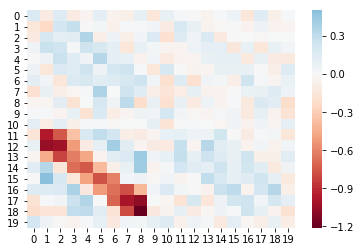

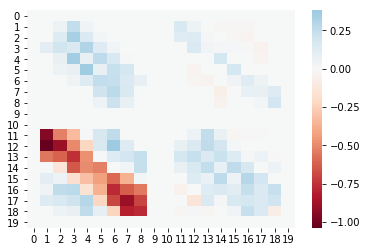

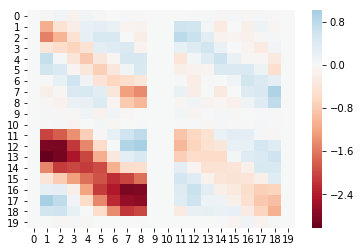

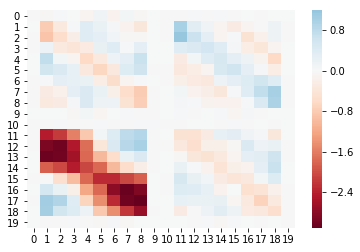

In [130]:
for n,exp in experiments.items():
    try:
        exp.post()
        #ani = naive_exp.make_animation()
        plt.figure()
        seaborn.heatmap(exp.all_omegas[-1], cmap='RdBu', center=0)
    except:
        print("Skipping ",n)